In [1]:
from dobbel import dobbellogger
from help_functies import *
dob = dobbellogger()

In [2]:
dob.connect()
dob.log(5, 100, 4, 250)
dob.download()
data = dob.datadf

Logging data for 5s
Done! The data is located in self.datadf


In [11]:
# Deze code niet vaker dan 1 keer uitvoeren!
data = remove_nan(data)
data = rotate_data(data)

gyro_bias = [-0.10488443, 0.48133019, -0.05951701]
acc_bias = [0.00462698, 0.02152201, -0.04949736]

data['x_gyro'] = data['x_gyro'] - gyro_bias[0]
data['y_gyro'] = data['y_gyro'] - gyro_bias[1]
data['z_gyro'] = data['z_gyro'] - gyro_bias[2]
data['x_acc'] = data['x_acc'] - acc_bias[0]
data['y_acc'] = data['y_acc'] - acc_bias[1]
data['z_acc'] = data['z_acc'] - acc_bias[2]

In [23]:
y11 = np.array([data['x_acc'][0], data['y_acc'][0], data['z_acc'][0]])
gb = y11 / np.linalg.norm(y11)
gn = np.array([0, 0, 1])
mn = np.array([1, 0, 0])
mb = np.array([1, 0, 0])

A = - np.matmul(left_quat_mul(np.array([0, *gn])), right_quat_mul(np.array([0, *gb]))) #- np.matmul(left_quat_mul(np.array([0, *mn])), right_quat_mul(np.array([0, *mb])))

# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(A)

# Eigenvalues are sorted in ascending order by np.linalg.eigh, 
# and the corresponding eigenvectors are columns of 'eigenvectors'
max_eigenvalue_index = np.argmax(eigenvalues)
max_eigenvector = eigenvectors[:, max_eigenvalue_index]

In [24]:
q11 = max_eigenvector

dqde = np.array([
    [0,0,0],
    [1,0,0],
    [0,1,0],
    [0,0,1]
])

sigma_etha = np.array([
    [(np.pi / 9) ** 2, 0, 0],
    [0, (np.pi / 9) ** 2, 0],
    [0, 0, (np.pi / 9) ** 2]
])

P11 = 0.25 * np.matmul(np.matmul(np.matmul(np.matmul(right_quat_mul(q11), dqde), sigma_etha), dqde.T), right_quat_mul(q11))

In [25]:
q = np.reshape(q11, 4)
q_list = [q]


for i in range(1, len(data['timestamp'])):
    dt = (data['timestamp'][i] - data['timestamp'][i - 1]) / 1000
    gyro_measurement = np.array([data['x_gyro'][i], data['y_gyro'][i], data['z_gyro'][i]])
    omega = gyro_measurement
    expq_omega = expq(omega, 0.5 * dt * np.pi / 180)
    q = quat_mul(q, expq_omega)
    q_list.append(q)

    

In [26]:
euler_x = []
euler_y = []
euler_z = []

for q, timestamp in zip(q_list, data['timestamp']):
    euler = quat_to_euler(q) * 180 / np.pi
    euler_x.append(euler[0])
    euler_y.append(euler[1])
    euler_z.append(euler[2])

C:\Users\jelte\AppData\Local\Temp\ipykernel_16032\2508345014.py:3: RuntimeWarning: invalid value encountered in scalar divide
  psi = np.arctan((2*x*y-2*w*z)/((2*w**2)+(2*x**2)-1))
C:\Users\jelte\AppData\Local\Temp\ipykernel_16032\2508345014.py:5: RuntimeWarning: invalid value encountered in scalar divide
  phi = np.arctan((2*y*z-2*w*x)/((2*w**2)+(2*z**2)-1))
C:\Users\jelte\AppData\Local\Temp\ipykernel_16032\2508345014.py:4: RuntimeWarning: invalid value encountered in arcsin
  theta = -np.arcsin(2*x*z+2*w*y)


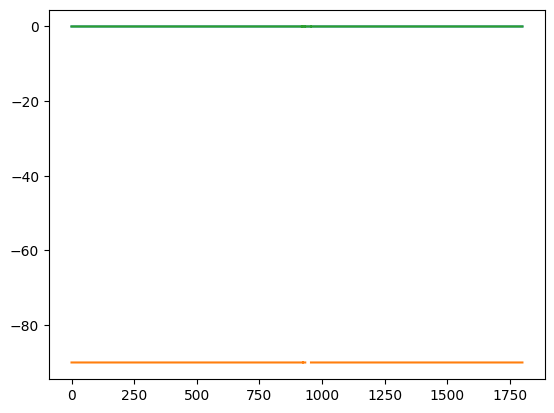

In [27]:
import matplotlib.pyplot as plt

plt.plot(euler_x)
plt.plot(euler_y)
plt.plot(euler_z)